In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline
import branch_kernParamGPflow as bk
import BranchingTree as bt

In [2]:
def InitialisePhiFromOMGP(mV, phiOMGP, b = 40.):     
    # branching location needed
    # create index
    N = Y.shape[0]
    assert phiOMGP.shape[0] == N
    assert phiOMGP.shape[1] == 2 # run OMGP with K=2 trajectories

    phiInitial = np.zeros((N, 3*N))
    # large neg number makes exact zeros, make smaller for added jitter
    phiInitial_invSoftmax = -9. * np.ones((N, 3*N))  
    XExpanded = np.zeros((3*N, 2))
    XExpanded[:] = np.nan
    #phiInitial[:] = np.nan
    eps = 1e-12
    iterC = 0
    for i,p in enumerate(pt):
        if(p <b): # before branching - it's the root
            phiInitial[i,iterC:iterC+3] = np.array([1-2*eps,0+eps,0+eps])
        else:
            phiInitial[i,iterC:iterC+3] = np.hstack([eps,phiOMGP[i,:]-eps])
        phiInitial_invSoftmax[i,iterC:iterC+3] = np.log(phiInitial[i,iterC:iterC+3] )
        XExpanded[iterC:iterC+3,0] = pt[i]
        XExpanded[iterC:iterC+3,1] = np.array(range(1,4)) 
        iterC += 3

    assert np.any(np.isnan(phiInitial)) == False, 'no nans plaase ' + str( np.nonzero(np.isnan(phiInitial)))
    assert np.any(phiInitial < 0) == False, 'no negatives plaase ' + str( np.nonzero(np.isnan(phiInitial)))
    assert np.any(np.isnan(XExpanded)) == False, 'no nans plaase in XExpanded ' 
    
    if(mV is not None):
        mV.logPhi = phiInitial_invSoftmax
    return phiInitial, phiInitial_invSoftmax, XExpanded

# VB Branching code

In [4]:
def FlattenPhi(mV):
    # return flattened and rounded Phi i.e. N X 3
    phiFlattened = np.zeros((mV.Y.shape[0],3)) # only single branching point
    Phi = np.round(np.exp(mV.logPhi._array),decimals=4)
    f=2 # which function to plot phi against - can be 1,2 or 3
    iterC=0
    for i,p in enumerate(mV.t):
        phiFlattened[i,:] = Phi[i,iterC:iterC+3] 
        iterC+=3
    return phiFlattened
Phi=FlattenPhi(mV)

NameError: name 'mV' is not defined

In [5]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10):
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
        plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # could also plot phi
    Phi=FlattenPhi(mV)
    gp_num = 1 # can be 0,1,2 
    plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
    plt.colorbar(label='GP {} assignment probability'.format(gp_num))


In [6]:
print 'Load initial allocation done through OMGP'
strMAPAllocation = 'InitialAllocationOMGP'
dictDataMAP = pickle.load(open( 'modelfiles/'+strMAPAllocation + '.p', "rb" )  )
XExpanded = dictDataMAP['XExpanded']
pt = dictDataMAP['pt']
m_phiOMGP = dictDataMAP['phiOMGP']
m_likvar = dictDataMAP['likvar']
m_lenscale = dictDataMAP['lenscale']
m_var = dictDataMAP['var']
l = pt.min() + 1
u = pt.max() - 1

Load initial allocation done through OMGP


In [8]:
def InitModels(pt, XExpanded, Y):
    # code that's a bit crappy - we dont need this
    tree = bt.BinaryBranchingTree(0,90,fDebug=False) # set to true to print debug messages
    tree.add(None,1,10) # single branching point
    (fm, _) = tree.GetFunctionBranchTensor()
    KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) # other copy of kernel
    KbranchVB.branchkernelparam.Bv.fixed = True
    mV = assigngp_dense.AssignGP(pt, XExpanded, Y, KbranchVB)
    mV.kern.white.variance = 1e-6
    mV.kern.white.variance.fixed = True
    mV._compile() # creates objective function
    return mV

# Look at gene expression

In [9]:
import pods
g = 'Id2'
print  'Load gene expression'
data = pods.datasets.singlecell()
genes = data['Y']  
Y = genes[g].values      
t0=time.time()  
mV = InitModels(pt, XExpanded, Y[:,None]) # also do gene by gene

Load gene expression
compiling tensorflow function...
done


In [12]:
dictDataGeneVB = pickle.load(open( 'modelfiles/gene'+g + '.p', "rb" )  )
print dictDataGeneVB
# plot best solution
mV.kern.branchkernelparam.Bv = dictDataGeneVB['x_opt'][0]
InitialisePhiFromOMGP(mV, phiOMGP=m_phiOMGP, b=dictDataGeneVB['x_opt'][0])   
mV.likelihood.variance = dictDataGeneVB['x_opt'][1]
mV.kern.branchkernelparam.kern.lengthscales = dictDataGeneVB['x_opt'][2]
mV.kern.branchkernelparam.kern.variance = dictDataGeneVB['x_opt'][3]

{'x_opt': array([ 84.28072347,   0.69573651,   2.58482547,   0.58128326]), 'fx_opt': array([ 853.65562777])}


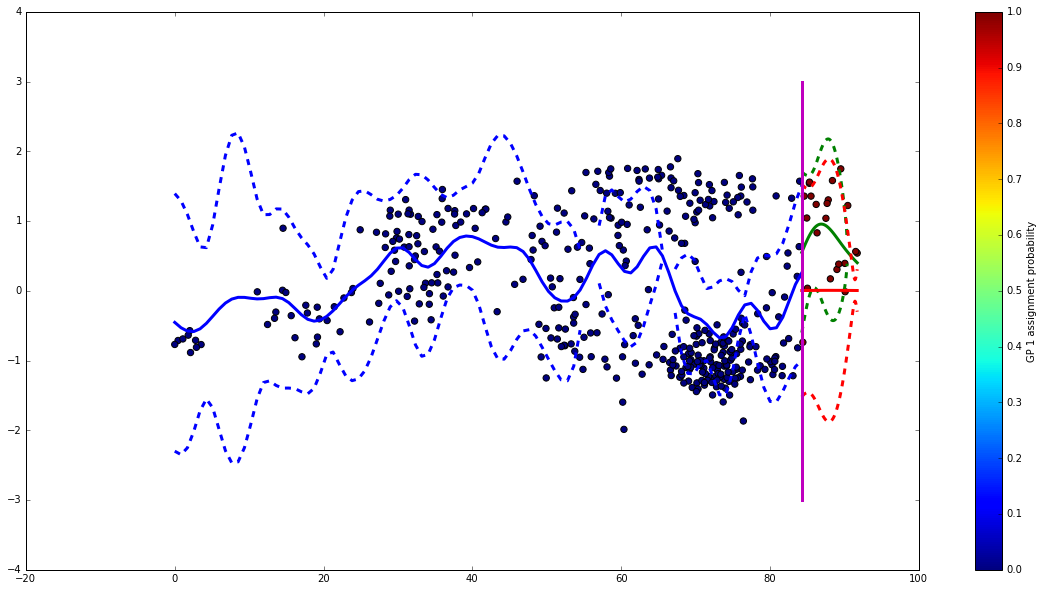

In [13]:
plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10)

In [14]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.Bv,[[ 84.28072347]],None,[FIXED]
model.kern.branchkernelparam.kern.variance,[ 0.58128326],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 2.58482547],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.likelihood.variance,[ 0.69573651],None,+ve
model.logPhi,"[[ -1.99995576e-12 -2.76310211e+01 -2.76310211e+01 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] ..., [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -1.99995576e-12 -2.76310211e+01 -2.76310211e+01]]",None,(none)


In [16]:
N = Y.shape[0]
labels = data['labels']
stageCell = np.zeros(N)
stageN = np.zeros(N)
for i,l in enumerate(labels):
    stageCell[i] = int(l[:2])
    stageN[i] = np.log2(stageCell[i]) + 1

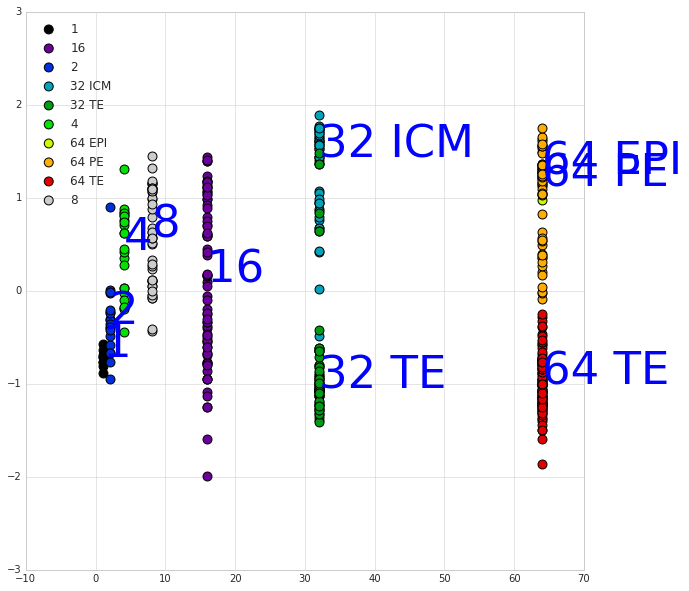

In [20]:
def plotGene(t,g,labels):
    import matplotlib.cm as cm
    labelLegend = np.unique(labels)
    with plt.style.context('seaborn-whitegrid'):
        colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
        plt.figure(figsize=(10, 10))
        for lab,c in zip(labelLegend,colors):
            y1 = t[labels == lab]
            y2 = g[labels == lab]
            plt.scatter(y1,y2,label=lab, c=c,s=80)
            plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
        plt.legend(loc='upper left')
plotGene(stageCell, Y, labels)

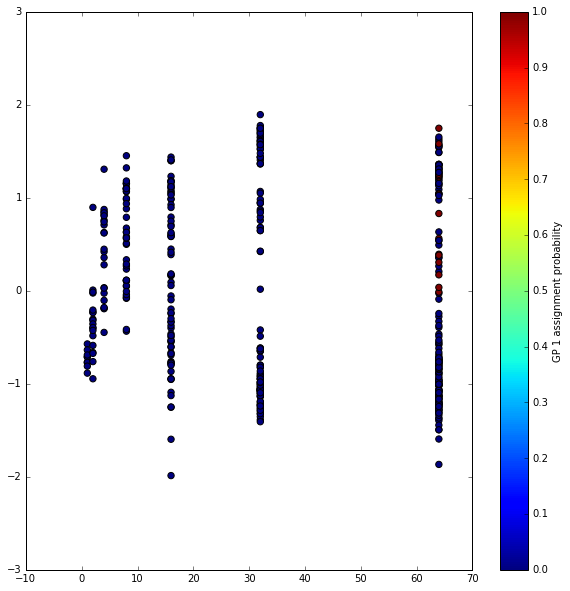

In [22]:
# could also plot phi
plt.figure(figsize=(10, 10))
Phi=FlattenPhi(mV)
gp_num = 1 # can be 0,1,2 
plt.scatter(stageCell, mV.Y, c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
plt.colorbar(label='GP {} assignment probability'.format(gp_num))